In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn import preprocessing
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn import *
from xgboost import XGBRegressor
from pylab import *
import glob, re
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [2]:
air_visit = pd.read_csv("air_visit_data.csv")
air_store = pd.read_csv("air_store_info.csv")
hpg_store = pd.read_csv("hpg_store_info.csv")
air_reserve = pd.read_csv("air_reserve.csv")
hpg_reserve = pd.read_csv("hpg_reserve.csv")
holidays = pd.read_csv("date_info.csv")
store_id = pd.read_csv("store_id_relation.csv")
test= pd.read_csv("sample_submission.csv")

In [3]:
air_visit.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [4]:
air_visit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252108 entries, 0 to 252107
Data columns (total 3 columns):
air_store_id    252108 non-null object
visit_date      252108 non-null object
visitors        252108 non-null int64
dtypes: int64(1), object(2)
memory usage: 5.8+ MB


In [5]:
air_visit_visitors_PerDay = pd.DataFrame(air_visit.groupby("visit_date")["visitors"].sum()).reset_index()
air_visit_visitors_PerDay.index +=1

In [6]:
air_visit_visitors_PerDay.head()

,visit_date,visitors
1,2016-01-01,1033
2,2016-01-02,1764
3,2016-01-03,2368
4,2016-01-04,3326
5,2016-01-05,3927


In [7]:
air_visit_visitors_PerDay["visit_date"]=pd.to_datetime(air_visit_visitors_PerDay["visit_date"])

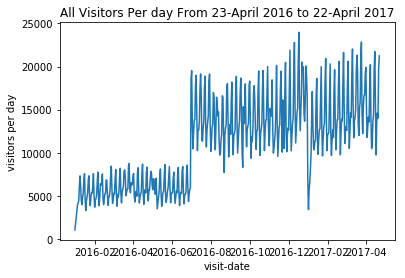

In [8]:
plt.plot(air_visit_visitors_PerDay["visit_date"],air_visit_visitors_PerDay["visitors"])

plt.xlabel("visit-date")
plt.ylabel("visitors per day")
plt.title("All Visitors Per day From 23-April 2016 to 22-April 2017")
plt.figure(figsize=(100,100))
plt.figure().subplots_adjust(bottom=0.2)
plt.show()

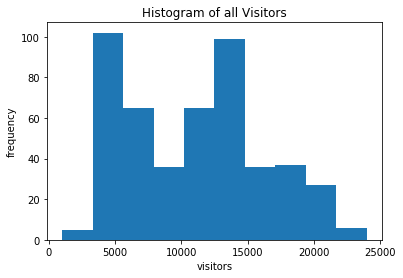

In [9]:
plt.hist(air_visit_visitors_PerDay["visitors"])
plt.xlabel("visitors")
plt.ylabel("frequency")
plt.title("Histogram of all Visitors")
plt.show()

In [10]:
air_visit_visitors_PerDay["weekday"]=air_visit_visitors_PerDay["visit_date"].apply(lambda x: x.weekday())

b =pd.DataFrame({"week" : ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],
"weekday" : [0,1,2,3,4,5,6]})
b.index +=1

In [11]:
air_visit_visitors_PerDay= air_visit_visitors_PerDay.merge(b,on="weekday")

In [12]:
x=pd.DataFrame(air_visit_visitors_PerDay.groupby("week")["visitors"].median()).reset_index()

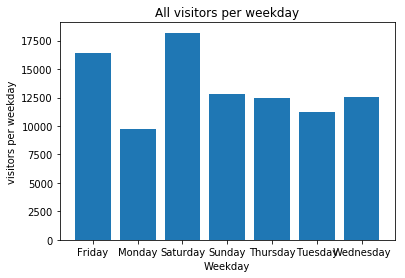

In [13]:
plt.bar(x["week"],x["visitors"])
plt.xlabel("Weekday")
plt.ylabel("visitors per weekday")
plt.title("All visitors per weekday")
plt.show()

In [14]:
air_visit_visitors_PerDay["month"]=air_visit_visitors_PerDay["visit_date"].dt.month
c =pd.DataFrame({"Month" : ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],
"month" : [1,2,3,4,5,6,7,8,9,10,11,12]})
c.index+=1
air_visit_visitors_PerDay = air_visit_visitors_PerDay.merge(c)

In [15]:
del air_visit_visitors_PerDay["month"]
del air_visit_visitors_PerDay["weekday"]


In [16]:
z=pd.DataFrame(air_visit_visitors_PerDay.groupby("Month")["visitors"].median()).reset_index()

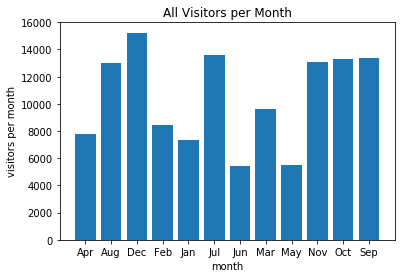

In [17]:
plt.bar(z["Month"],z["visitors"])
plt.xlabel("month")
plt.ylabel("visitors per month")
plt.title("All Visitors per Month")
plt.show()

In [18]:
air_visit_visitors_PerDay = air_visit_visitors_PerDay.set_index("visit_date")


In [19]:
req_df = air_visit_visitors_PerDay.loc["2016-04-23":"2016-05-31"]
req_df = req_df.reset_index(level=0)
req_df =req_df.sort_values(by="visit_date")

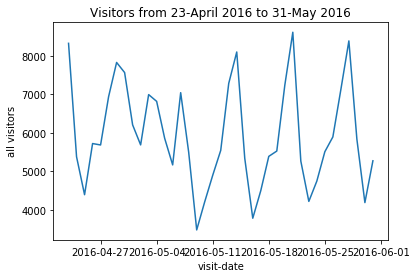

In [20]:
plt.plot(req_df["visit_date"],req_df["visitors"])
plt.xlabel("visit-date")
plt.ylabel("all visitors")
plt.title("Visitors from 23-April 2016 to 31-May 2016")
plt.figure(figsize=(100,100))
plt.figure().subplots_adjust(bottom=0.2)
plt.show()

# Air Reservations Data

In [21]:
air_reserve.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92378 entries, 0 to 92377
Data columns (total 4 columns):
air_store_id        92378 non-null object
visit_datetime      92378 non-null object
reserve_datetime    92378 non-null object
reserve_visitors    92378 non-null int64
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


In [22]:
air_reserve["visit_datetime"] = pd.to_datetime(air_reserve["visit_datetime"])

In [23]:
data = air_reserve[["visit_datetime","reserve_visitors"]]

In [24]:
data = data.set_index("visit_datetime").resample("D").sum()

In [25]:
data= data.reset_index()

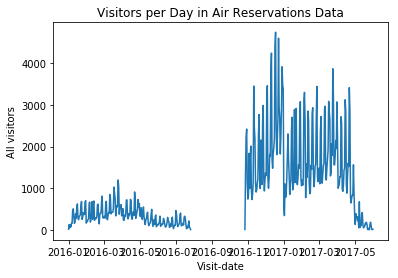

In [26]:
plt.plot(data["visit_datetime"],data["reserve_visitors"])
plt.xlabel("Visit-date")
plt.ylabel("All visitors")
plt.title("Visitors per Day in Air Reservations Data")
plt.figure(figsize=(100,100))

plt.show()

In [27]:
air_reserve_1 = air_reserve[["visit_datetime","reserve_visitors"]]

In [28]:
air_reserve_1["visit_hour"] =  air_reserve_1.visit_datetime.dt.hour

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [29]:
air_reserve_1.head()

,visit_datetime,reserve_visitors,visit_hour
0,2016-01-01 19:00:00,1,19
1,2016-01-01 19:00:00,3,19
2,2016-01-01 19:00:00,6,19
3,2016-01-01 20:00:00,2,20
4,2016-01-01 20:00:00,5,20


In [30]:
air_reserve_1_req = pd.DataFrame(air_reserve_1.groupby("visit_hour")["reserve_visitors"].sum())

In [31]:
air_reserve_1_req = air_reserve_1_req.reset_index()

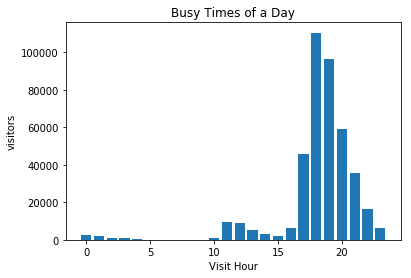

In [32]:
plt.bar(air_reserve_1_req["visit_hour"],air_reserve_1_req["reserve_visitors"])
plt.xlabel("Visit Hour")
plt.ylabel("visitors")
plt.title("Busy Times of a Day")
plt.show()

In [33]:
air_reserve.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [34]:
air_reserve["reserve_datetime"]=pd.to_datetime(air_reserve["reserve_datetime"])

In [35]:
air_reserve.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92378 entries, 0 to 92377
Data columns (total 4 columns):
air_store_id        92378 non-null object
visit_datetime      92378 non-null datetime64[ns]
reserve_datetime    92378 non-null datetime64[ns]
reserve_visitors    92378 non-null int64
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 2.8+ MB


In [36]:
air_reserve["timeDiff"]=(air_reserve["visit_datetime"]-air_reserve["reserve_datetime"]).astype('timedelta64[h]')

In [37]:
air_reserve["days"] = air_reserve["timeDiff"]/24

In [38]:
air_reserve[air_reserve["days"] > 360]

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,timeDiff,days
50772,air_2a485b92210c98b5,2017-01-18 20:00:00,2016-01-14 23:00:00,2,8877.0,369.875000
50773,air_2a485b92210c98b5,2017-01-18 20:00:00,2016-01-15 13:00:00,3,8863.0,369.291667
50774,air_2a485b92210c98b5,2017-01-18 20:00:00,2016-01-03 12:00:00,4,9152.0,381.333333
50797,air_2a485b92210c98b5,2017-01-18 20:00:00,2016-01-18 08:00:00,2,8796.0,366.500000
50799,air_2a485b92210c98b5,2017-01-18 20:00:00,2016-01-17 18:00:00,2,8810.0,367.083333
50805,air_2a485b92210c98b5,2017-01-18 20:00:00,2016-01-02 20:00:00,2,9168.0,382.000000
50806,air_2a485b92210c98b5,2017-01-18 20:00:00,2016-01-06 17:00:00,20,9075.0,378.125000
50809,air_2a485b92210c98b5,2017-01-18 20:00:00,2016-01-02 21:00:00,6,9167.0,381.958333
50813,air_2a485b92210c98b5,2017-01-18 20:00:00,2016-01-05 16:00:00,2,9100.0,379.166667
50826,air_2a485b92210c98b5,2017-01-18 20:00:00,2016-01-02 00:00:00,4,9188.0,382.833333


# HPG Reserve data

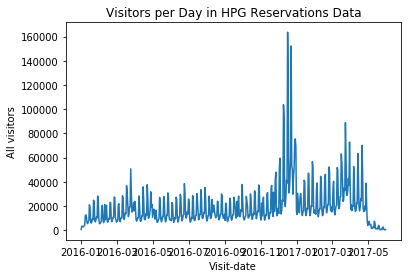

In [39]:
hpg_reserve["visit_datetime"] = pd.to_datetime(hpg_reserve["visit_datetime"])
data_2 = hpg_reserve[["visit_datetime","reserve_visitors"]]
data_2 = data_2.set_index("visit_datetime").resample("D").sum()
data_2= data_2.reset_index()
plt.plot(data_2["visit_datetime"],data_2["reserve_visitors"])
plt.xlabel("Visit-date")
plt.ylabel("All visitors")
plt.title("Visitors per Day in HPG Reservations Data")
plt.figure(figsize=(100,100))

plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


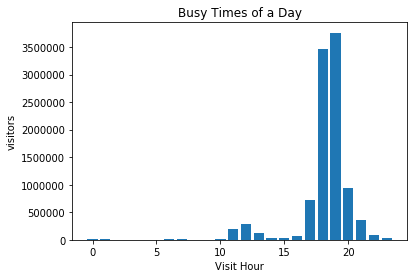

In [40]:
hpg_reserve_1 = hpg_reserve[["visit_datetime","reserve_visitors"]]
hpg_reserve_1["visit_hour"] =  hpg_reserve_1.visit_datetime.dt.hour
hpg_reserve_1_req = pd.DataFrame(hpg_reserve_1.groupby("visit_hour")["reserve_visitors"].sum())
hpg_reserve_1_req = hpg_reserve_1_req.reset_index()
plt.bar(hpg_reserve_1_req["visit_hour"],hpg_reserve_1_req["reserve_visitors"])
plt.xlabel("Visit Hour")
plt.ylabel("visitors")
plt.title("Busy Times of a Day")
plt.show()

In [41]:
hpg_reserve["reserve_datetime"]=pd.to_datetime(hpg_reserve["reserve_datetime"])
hpg_reserve["timeDiff"]=(hpg_reserve["visit_datetime"]-hpg_reserve["reserve_datetime"]).astype('timedelta64[h]')
hpg_reserve["days"] = hpg_reserve["timeDiff"]/24
hpg_reserve[hpg_reserve["days"] > 360]

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,timeDiff,days
1605287,hpg_27220c59393af3ff,2017-02-23 19:00:00,2016-02-21 16:00:00,2,8835.0,368.125
1847912,hpg_f1e9bb84d62ac5e6,2017-04-01 19:00:00,2016-04-04 19:00:00,5,8688.0,362.000


# Air Store Data

In [42]:
air_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 5 columns):
air_store_id      829 non-null object
air_genre_name    829 non-null object
air_area_name     829 non-null object
latitude          829 non-null float64
longitude         829 non-null float64
dtypes: float64(2), object(3)
memory usage: 32.5+ KB


In [43]:
air_store_genreWise = pd.DataFrame(air_store.groupby("air_genre_name")["air_store_id"].count()).reset_index()
air_store_genreWise.index+=1
air_store_genreWise = air_store_genreWise.rename(columns={"air_store_id":"noOfRest"})
air_store_genreWise = air_store_genreWise.sort_values(by="noOfRest",ascending=False)

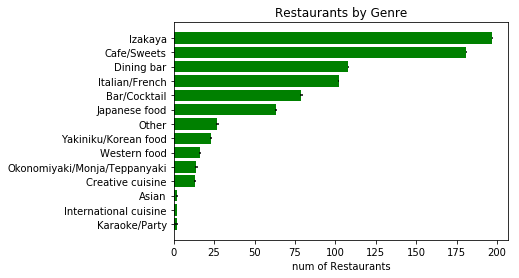

In [44]:
fig, ax = plt.subplots()
error = np.random.rand(len(air_store_genreWise["air_genre_name"]))
y_pos = np.arange(len(air_store_genreWise["air_genre_name"]))
ax.barh(y_pos, air_store_genreWise["noOfRest"], xerr=error, align='center',
        color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(air_store_genreWise["air_genre_name"])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('num of Restaurants')
ax.set_title('Restaurants by Genre')

plt.show()

In [45]:
air_store_areaWise = pd.DataFrame(air_store.groupby("air_area_name")["air_store_id"].count()).reset_index()
air_store_areaWise.index+=1
air_store_areaWise = air_store_areaWise.rename(columns={"air_store_id":"noOfRest"})
air_store_areaWise=air_store_areaWise.sort_values(by="noOfRest",ascending=False)[:16]

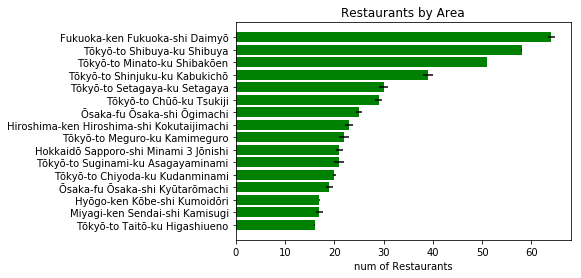

In [46]:
fig, ax = plt.subplots()
error2 = np.random.rand(len(air_store_areaWise["air_area_name"]))
y_pos2 = np.arange(len(air_store_areaWise["air_area_name"]))
ax.barh(y_pos2, air_store_areaWise["noOfRest"], xerr=error2, align='center',
        color='green', ecolor='black')
ax.set_yticks(y_pos2)
ax.set_yticklabels(air_store_areaWise["air_area_name"])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('num of Restaurants')
ax.set_title('Restaurants by Area')

plt.show()

In [47]:
hpg_store.head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


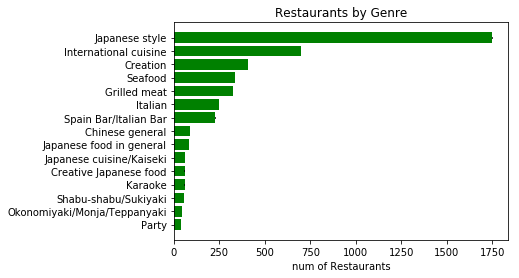

In [48]:
hpg_store_genreWise = pd.DataFrame(hpg_store.groupby("hpg_genre_name")["hpg_store_id"].count()).reset_index()
hpg_store_genreWise.index+=1
hpg_store_genreWise = hpg_store_genreWise.rename(columns={"hpg_store_id":"noOfRest"})
hpg_store_genreWise = hpg_store_genreWise.sort_values(by="noOfRest",ascending=False)[:15]
fig, ax = plt.subplots()
error = np.random.rand(len(hpg_store_genreWise["hpg_genre_name"]))
y_pos = np.arange(len(hpg_store_genreWise["hpg_genre_name"]))
ax.barh(y_pos, hpg_store_genreWise["noOfRest"], xerr=error, align='center',
        color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(hpg_store_genreWise["hpg_genre_name"])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('num of Restaurants')
ax.set_title('Restaurants by Genre')

plt.show()

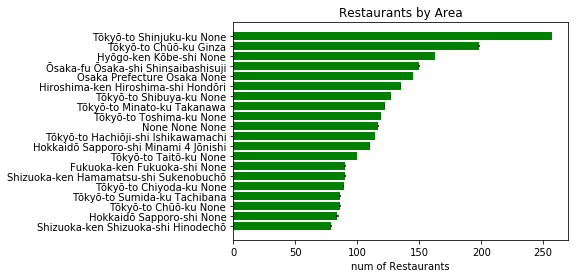

In [49]:
hpg_store_areaWise = pd.DataFrame(hpg_store.groupby("hpg_area_name")["hpg_store_id"].count()).reset_index()
hpg_store_areaWise.index+=1
hpg_store_areaWise = hpg_store_areaWise.rename(columns={"hpg_store_id":"noOfRest"})
hpg_store_areaWise=hpg_store_areaWise.sort_values(by="noOfRest",ascending=False)[:20]
fig, ax = plt.subplots()
error2 = np.random.rand(len(hpg_store_areaWise["hpg_area_name"]))
y_pos2 = np.arange(len(hpg_store_areaWise["hpg_area_name"]))
ax.barh(y_pos2, hpg_store_areaWise["noOfRest"], xerr=error2, align='center',
        color='green', ecolor='black')
ax.set_yticks(y_pos2)
ax.set_yticklabels(hpg_store_areaWise["hpg_area_name"])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('num of Restaurants')
ax.set_title('Restaurants by Area')

plt.show()

# Data Transformations

In [50]:
hpg_reserve = pd.merge(hpg_reserve, store_id, how='inner', on=['hpg_store_id'])


In [51]:
hpg_reserve.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,timeDiff,days,air_store_id
0,hpg_878cc70b1abc76f7,2016-01-01 19:00:00,2016-01-01 15:00:00,4,4.0,0.166667,air_db80363d35f10926
1,hpg_878cc70b1abc76f7,2016-01-02 19:00:00,2016-01-02 14:00:00,2,5.0,0.208333,air_db80363d35f10926
2,hpg_878cc70b1abc76f7,2016-01-03 18:00:00,2016-01-02 20:00:00,6,22.0,0.916667,air_db80363d35f10926
3,hpg_878cc70b1abc76f7,2016-01-06 20:00:00,2016-01-04 22:00:00,3,46.0,1.916667,air_db80363d35f10926
4,hpg_878cc70b1abc76f7,2016-01-11 18:00:00,2016-01-11 14:00:00,2,4.0,0.166667,air_db80363d35f10926


converted to datetime, found out the no of days between reservation and visiting,created a dataframe t1 consisting of sum of  diff in days for every store id and visit data and created a dataframe  t2 consisting of mean of days diff and visitors diff for every air store id and visit date and combined t1 and t2

In [52]:
air_reserve["visit_datetime"]= pd.to_datetime(air_reserve["visit_datetime"])
air_reserve["visit_datetime"] = air_reserve["visit_datetime"].dt.date
air_reserve["reserve_datetime"]= pd.to_datetime(air_reserve["reserve_datetime"])
air_reserve["reserve_datetime"] = air_reserve["reserve_datetime"].dt.date
air_reserve["reserve_datetime_diff"]= air_reserve.apply(lambda r: (r["visit_datetime"]-r["reserve_datetime"]).days,axis=1)
t1 = air_reserve.groupby(["air_store_id","visit_datetime"],as_index=False)[["reserve_datetime_diff","reserve_visitors"]].sum().rename(columns={"visit_datetime":"visit_date","reserve_datetime_diff":"rs1","reserve_visitors":"rv1"})
t2 = air_reserve.groupby(["air_store_id","visit_datetime"],as_index=False)[["reserve_datetime_diff","reserve_visitors"]].mean().rename(columns={"visit_datetime":"visit_date","reserve_datetime_diff":"rs2","reserve_visitors":"rv2"})
air_reserve = pd.merge(t1,t2,how="inner",on=["air_store_id","visit_date"])

In [53]:
air_reserve.head()

,air_store_id,visit_date,rs1,rv1,rs2,rv2
0,air_00a91d42b08b08d9,2016-10-31,0,2,0.0,2.0
1,air_00a91d42b08b08d9,2016-12-05,4,9,4.0,9.0
2,air_00a91d42b08b08d9,2016-12-14,6,18,6.0,18.0
3,air_00a91d42b08b08d9,2016-12-17,6,2,6.0,2.0
4,air_00a91d42b08b08d9,2016-12-20,2,4,2.0,4.0


In [54]:
hpg_reserve["visit_datetime"]= pd.to_datetime(hpg_reserve["visit_datetime"])
hpg_reserve["visit_datetime"] = hpg_reserve["visit_datetime"].dt.date
hpg_reserve["reserve_datetime"]= pd.to_datetime(hpg_reserve["reserve_datetime"])
hpg_reserve["reserve_datetime"] = hpg_reserve["reserve_datetime"].dt.date
hpg_reserve["reserve_datetime_diff"]= hpg_reserve.apply(lambda r: (r["visit_datetime"]-r["reserve_datetime"]).days,axis=1)
t11 = hpg_reserve.groupby(["air_store_id","visit_datetime"],as_index=False)[["reserve_datetime_diff","reserve_visitors"]].sum().rename(columns={"visit_datetime":"visit_date","reserve_datetime_diff":"rs1","reserve_visitors":"rv1"})
t22 = hpg_reserve.groupby(["air_store_id","visit_datetime"],as_index=False)[["reserve_datetime_diff","reserve_visitors"]].mean().rename(columns={"visit_datetime":"visit_date","reserve_datetime_diff":"rs2","reserve_visitors":"rv2"})
hpg_reserve = pd.merge(t11,t22,how="inner",on=["air_store_id","visit_date"])

In [55]:
air_visit_1 = pd.read_csv("air_visit_data.csv")


In [56]:
air_visit_1["visit_date"] = pd.to_datetime(air_visit_1["visit_date"])
air_visit_1['DayofWeek'] = air_visit_1['visit_date'].dt.dayofweek
air_visit_1['year'] = air_visit_1['visit_date'].dt.year
air_visit_1['month'] = air_visit_1['visit_date'].dt.month
air_visit_1['visit_date'] = air_visit_1['visit_date'].dt.date

In [57]:
test["visit_date"]=test["id"].map(lambda x: str(x).split("_")[2])
test["air_store_id"]=test["id"].map(lambda x: "_".join(x.split("_")[:2]))
test["visit_date"] = pd.to_datetime(test["visit_date"])
test["DayofWeek"] = test["visit_date"].dt.dayofweek
test["year"] = test["visit_date"].dt.year
test["month"] = test["visit_date"].dt.month
test["visit_date"] = test["visit_date"].dt.date

In [58]:
distinct_stores=test["air_store_id"].unique()
stores=pd.concat([pd.DataFrame({"air_store_id":distinct_stores,"DayofWeek":[i]*len(distinct_stores)}) for i in range(7)],axis=0,ignore_index=True).reset_index(drop=True)

In [59]:
t = air_visit_1.groupby(["air_store_id","DayofWeek"],as_index=False)["visitors"].min().rename(columns={"visitors":"min_visitors"})
stores=pd.merge(stores,t,how="left",on=["air_store_id","DayofWeek"])

t = air_visit_1.groupby(["air_store_id","DayofWeek"],as_index=False)["visitors"].mean().rename(columns={"visitors":"mean_visitors"})
stores= pd.merge(stores,t,how="left",on=["air_store_id","DayofWeek"])

t = air_visit_1.groupby(["air_store_id","DayofWeek"],as_index=False)["visitors"].median().rename(columns={"visitors":"median_visitors"})
stores= pd.merge(stores,t,how="left",on=["air_store_id","DayofWeek"])

t = air_visit_1.groupby(["air_store_id","DayofWeek"],as_index=False)["visitors"].max().rename(columns={"visitors":"max_visitors"})
stores= pd.merge(stores,t,how="left",on=["air_store_id","DayofWeek"])

t = air_visit_1.groupby(["air_store_id","DayofWeek"],as_index=False)["visitors"].count().rename(columns={"visitors":"count_visitors"})
stores= pd.merge(stores,t,how="left",on=["air_store_id","DayofWeek"])

k2 = air_visit_1.groupby(["air_store_id"]).agg({"visitors":[np.mean,np.std]}).reset_index()
k2.columns=["air_store_id","mean_visitorso","std_devo"]
stores=pd.merge(stores,k2,how="left",on=["air_store_id"])
stores=pd.merge(stores,air_store,how="left",on=["air_store_id"])

# New Features

In [60]:
stores.head()

,DayofWeek,air_store_id,min_visitors,mean_visitors,median_visitors,max_visitors,count_visitors,mean_visitorso,std_devo,air_genre_name,air_area_name,latitude,longitude
0,0,air_00a91d42b08b08d9,1.0,22.457143,19.0,47.0,35.0,26.081897,12.435364,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
1,0,air_0164b9927d20bcc3,2.0,7.500000,6.0,19.0,20.0,9.248322,6.348980,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,0,air_0241aa3964b7f861,2.0,8.920635,8.0,23.0,63.0,9.896465,6.214877,Izakaya,Tōkyō-to Taitō-ku Higashiueno,35.712607,139.779996
3,0,air_0328696196e46f18,2.0,6.416667,4.0,27.0,12.0,7.939655,6.733807,Dining bar,Ōsaka-fu Ōsaka-shi Nakanochō,34.701279,135.528090
4,0,air_034a3d5b40d5b1b1,1.0,11.864865,10.0,66.0,37.0,14.828685,13.154107,Cafe/Sweets,Ōsaka-fu Ōsaka-shi Ōhiraki,34.692337,135.472229


In [61]:
stores["air_genre_name"]=stores["air_genre_name"].map(lambda x: str(str(x).replace("/"," ")))
stores["air_area_name"]= stores["air_area_name"].map(lambda x: str(str(x).replace("-"," ")))
labelEncode = preprocessing.LabelEncoder()

In [62]:
stores.head()

,DayofWeek,air_store_id,min_visitors,mean_visitors,median_visitors,max_visitors,count_visitors,mean_visitorso,std_devo,air_genre_name,air_area_name,latitude,longitude
0,0,air_00a91d42b08b08d9,1.0,22.457143,19.0,47.0,35.0,26.081897,12.435364,Italian French,Tōkyō to Chiyoda ku Kudanminami,35.694003,139.753595
1,0,air_0164b9927d20bcc3,2.0,7.500000,6.0,19.0,20.0,9.248322,6.348980,Italian French,Tōkyō to Minato ku Shibakōen,35.658068,139.751599
2,0,air_0241aa3964b7f861,2.0,8.920635,8.0,23.0,63.0,9.896465,6.214877,Izakaya,Tōkyō to Taitō ku Higashiueno,35.712607,139.779996
3,0,air_0328696196e46f18,2.0,6.416667,4.0,27.0,12.0,7.939655,6.733807,Dining bar,Ōsaka fu Ōsaka shi Nakanochō,34.701279,135.528090
4,0,air_034a3d5b40d5b1b1,1.0,11.864865,10.0,66.0,37.0,14.828685,13.154107,Cafe Sweets,Ōsaka fu Ōsaka shi Ōhiraki,34.692337,135.472229


In [63]:
for i in range(10):
    stores["air_genre_name"+str(i)] = labelEncode.fit_transform(stores["air_genre_name"].map(lambda x: str(str(x).split(" ")[i]) if len(str(x).split(" ")) >i else ""))
    stores["air_area_name"+str(i)] = labelEncode.fit_transform(stores["air_area_name"].map(lambda x: str(str(x).split(" ")[i]) if len(str(x).split(" ")) >i else ""))
stores["air_genre_name"] = labelEncode.fit_transform(stores["air_genre_name"])
stores["air_area_name"] = labelEncode.fit_transform(stores["air_area_name"])
stores['area']=stores['air_area_name'].map(lambda x: str(str(x).split(' ')[:2]))
stores['area']=labelEncode.fit_transform(stores['area'])
stores['area']=stores['air_area_name'].map(lambda x: str(str(x).split(' ')[:2]))
stores['area']=labelEncode.fit_transform(stores['area'])

In [64]:
stores.head()

,DayofWeek,air_store_id,min_visitors,mean_visitors,median_visitors,max_visitors,count_visitors,mean_visitorso,std_devo,air_genre_name,...,air_area_name5,air_genre_name6,air_area_name6,air_genre_name7,air_area_name7,air_genre_name8,air_area_name8,air_genre_name9,air_area_name9,area
0,0,air_00a91d42b08b08d9,1.0,22.457143,19.0,47.0,35.0,26.081897,12.435364,6,...,0,0,0,0,0,0,0,0,0,42
1,0,air_0164b9927d20bcc3,2.0,7.500000,6.0,19.0,20.0,9.248322,6.348980,6,...,0,0,0,0,0,0,0,0,0,62
2,0,air_0241aa3964b7f861,2.0,8.920635,8.0,23.0,63.0,9.896465,6.214877,7,...,0,0,0,0,0,0,0,0,0,84
3,0,air_0328696196e46f18,2.0,6.416667,4.0,27.0,12.0,7.939655,6.733807,4,...,0,0,0,0,0,0,0,0,0,101
4,0,air_034a3d5b40d5b1b1,1.0,11.864865,10.0,66.0,37.0,14.828685,13.154107,2,...,0,0,0,0,0,0,0,0,0,5


In [65]:
holidays = holidays.rename(columns={"calendar_date":"visit_date"})
holidays["visit_date"] = pd.to_datetime(holidays["visit_date"])
holidays["day_of_week"] = labelEncode.fit_transform(holidays["day_of_week"])
holidays["visit_date"] = holidays["visit_date"].dt.date

In [66]:
train = pd.merge(air_visit_1,holidays,how="left",on=["visit_date"])
test = pd.merge(test,holidays,how="left",on=["visit_date"])

train = pd.merge(train,stores,how="left",on=["air_store_id","DayofWeek"])
test = pd.merge(test,stores,how="left",on=["air_store_id","DayofWeek"])
    

In [67]:
for df in [air_reserve,hpg_reserve]:
    train = pd.merge(train, df, how='left', on=['air_store_id','visit_date']) 
    test = pd.merge(test, df, how='left', on=["air_store_id","visit_date"])
    



In [68]:
test.head()

,id,visitors,visit_date,air_store_id,DayofWeek,year,month,day_of_week,holiday_flg,min_visitors,...,air_area_name9,area,rs1_x,rv1_x,rs2_x,rv2_x,rs1_y,rv1_y,rs2_y,rv2_y
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air_00a91d42b08b08d9,6,2017,4,3,0,2.0,...,0,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air_00a91d42b08b08d9,0,2017,4,1,0,1.0,...,0,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air_00a91d42b08b08d9,1,2017,4,5,0,1.0,...,0,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,air_00a91d42b08b08d9,2,2017,4,6,0,15.0,...,0,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,air_00a91d42b08b08d9,3,2017,4,4,0,15.0,...,0,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
train["id"] = train.apply(lambda r: '_'.join([str(r['air_store_id']), str(r['visit_date'])]), axis=1)
    

In [70]:
train['total_reserv_sum'] = train['rv1_x'] + train['rv1_y']
train['total_reserv_mean'] = (train['rv2_x'] + train['rv2_y']) / 2
train['total_reserv_dt_diff_mean'] = (train['rs2_x'] + train['rs2_y']) / 2

test['total_reserv_sum'] = test['rv1_x'] + test['rv1_y']
test['total_reserv_mean'] = (test['rv2_x'] + test['rv2_y']) / 2
test['total_reserv_dt_diff_mean'] = (test['rs2_x'] + test['rs2_y']) / 2

In [71]:
train['date_int'] = train['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
test['date_int'] = test['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
train['var_max_lat'] = train['latitude'].max() - train['latitude']
train['var_max_long'] = train['longitude'].max() - train['longitude']
test['var_max_lat'] = test['latitude'].max() - test['latitude']
test['var_max_long'] = test['longitude'].max() - test['longitude']

In [72]:
test['date_int'] = test['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
test['var_max_lat'] = test['latitude'].max() - test['latitude']
test['var_max_long'] = test['longitude'].max() - test['longitude']

In [73]:
test.head()

,id,visitors,visit_date,air_store_id,DayofWeek,year,month,day_of_week,holiday_flg,min_visitors,...,rs1_y,rv1_y,rs2_y,rv2_y,total_reserv_sum,total_reserv_mean,total_reserv_dt_diff_mean,date_int,var_max_lat,var_max_long
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air_00a91d42b08b08d9,6,2017,4,3,0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20170423,8.326629,4.519803
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air_00a91d42b08b08d9,0,2017,4,1,0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20170424,8.326629,4.519803
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air_00a91d42b08b08d9,1,2017,4,5,0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20170425,8.326629,4.519803
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,air_00a91d42b08b08d9,2,2017,4,6,0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20170426,8.326629,4.519803
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,air_00a91d42b08b08d9,3,2017,4,4,0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20170427,8.326629,4.519803


In [74]:
train['lon_plus_lat'] = train['longitude'] + train['latitude'] 
test['lon_plus_lat'] = test['longitude'] + test['latitude']


train['air_store_id2'] = labelEncode.fit_transform(train['air_store_id'])
test['air_store_id2'] = labelEncode.transform(test['air_store_id'])

col = [c for c in train if c not in ['id', 'air_store_id', 'visit_date','visitors']]
train = train.fillna(-1)
test = test.fillna(-1)

In [75]:
def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5

In [76]:


model3= XGBRegressor(learning_rate=0.2, random_state=3, n_estimators=200, subsample=0.8,colsample_bytree=0.8, max_depth =10,n_jobs=-1)

In [77]:


model3.fit(train[col], np.log1p(train['visitors'].values))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=3,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [78]:
model2= neighbors.KNeighborsRegressor(n_jobs=-1,n_neighbors=4)

In [79]:
model2.fit(train[col], np.log1p(train['visitors'].values))

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
          weights='uniform')

In [80]:

predictions2 = model2.predict(train[col])
predictions3 = model3.predict(train[col])

In [81]:

print('RMSE KNeighborsRegressor: ', RMSLE(np.log1p(train['visitors'].values), predictions2))
print('RMSE XGBRegressor: ', RMSLE(np.log1p(train['visitors'].values), predictions3))

RMSE KNeighborsRegressor:  0.419651610955
RMSE XGBRegressor:  0.438746425671


In [82]:
test_preds2 = model2.predict(test[col])
test_preds3 = model3.predict(test[col])

In [83]:
test['visitors'] = 0.4*test_preds2+0.6*test_preds3
test['visitors'] = np.expm1(test['visitors']).clip(lower=0.)
sub1 = test[['id','visitors']].copy()

In [84]:
date_info = pd.read_csv("date_info.csv")
visit_data=pd.read_csv("air_visit_data.csv")
sample_submission = pd.read_csv("sample_submission.csv")

In [85]:
date_info.head()

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [87]:

wkend_holidays = date_info.apply((lambda x:(x.day_of_week=='Sunday' or x.day_of_week=='Saturday') and x.holiday_flg==1), axis=1)
date_info.loc[wkend_holidays, 'holiday_flg'] = 0
date_info['weight'] = ((date_info.index + 1) / len(date_info)) ** 5  

visit_data = visit_data.merge(date_info, left_on='visit_date', right_on='calendar_date', how='left')
visit_data.drop('calendar_date', axis=1, inplace=True)
visit_data['visitors'] = visit_data.visitors.map(pd.np.log1p)

wmean = lambda x:( (x.weight * x.visitors).sum() / x.weight.sum() )
visitors = visit_data.groupby(['air_store_id', 'day_of_week', 'holiday_flg']).apply(wmean).reset_index()
visitors.rename(columns={0:'visitors'}, inplace=True)

In [88]:
sample_submission['air_store_id'] = sample_submission.id.map(lambda x: '_'.join(x.split('_')[:-1]))
sample_submission['calendar_date'] = sample_submission.id.map(lambda x: x.split('_')[2])
sample_submission.drop('visitors', axis=1, inplace=True)
sample_submission = sample_submission.merge(date_info, on='calendar_date', how='left')
sample_submission = sample_submission.merge(visitors, on=['air_store_id', 'day_of_week', 'holiday_flg'], how='left')

In [89]:
missings = sample_submission.visitors.isnull()
sample_submission.loc[missings, 'visitors'] = sample_submission[missings].merge(visitors[visitors.holiday_flg==0], on=('air_store_id', 'day_of_week'),how='left')['visitors_y'].values

missings = sample_submission.visitors.isnull()
sample_submission.loc[missings, 'visitors'] = sample_submission[missings].merge(visitors[['air_store_id', 'visitors']].groupby('air_store_id').mean().reset_index(), on='air_store_id', how='left')['visitors_y'].values

In [90]:
sample_submission['visitors'] = sample_submission.visitors.map(pd.np.expm1)
sub2 = sample_submission[['id', 'visitors']].copy()
sub_merge = pd.merge(sub1, sub2, on='id', how='inner')

In [91]:
sub_merge['visitors'] = 0.6*sub_merge['visitors_x'] + 0.4*sub_merge['visitors_y']* 1.1
sub_merge[['id', 'visitors']].to_csv('submission3.csv', index=False)